In [25]:
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt


class Particle:
    def __init__(self, n_clusters, data, use_kmeans=True, w=0.72, c1=1.49, c2=1.49):
        self.n_clusters = n_clusters
        if use_kmeans:
            k_means = KMeans(n_clusters=self.n_clusters)
            k_means.fit(data)
            self.centroids_pos = k_means.cluster_centers_
        else:
            self.centroids_pos = data[np.random.choice(list(range(len(data))), self.n_clusters)]

        # each cluster has a centroid which is the point that represents that cluster
        # assign k random data to k centroids
        self.pb_val = np.inf
        # personal best position for all the centroids so far
        self.pb_pos = self.centroids_pos.copy()
        self.velocity = np.zeros_like(self.centroids_pos)
        # best data clustering so far
        self.pb_clustering = None
        # pso params
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def update_pb(self, data: np.ndarray):
        """
        Updates personal best score based on the fitness function mentioned in the paper (Equation(4))
        :return:
        """
        # finding out which data points belongs to which cluster
        # for that we have to find the distance between the data points and the centroids.
        distances = self._get_distances(data=data)
        # the minimum distance between a data point and a centroid indicates that, the point belongs to that cluster.
        clusters = np.argmin(distances, axis=0)  # shape: (len(data),)
        clusters_ids = np.unique(clusters)

        # This is for when the algorithm generates less than n clusters
        # So we find the cluster id that is missed and generate the centroid position with a random data point
        while len(clusters_ids) != self.n_clusters:
            deleted_clusters = np.where(np.isin(np.arange(self.n_clusters), clusters_ids) == False)[0]
            self.centroids_pos[deleted_clusters] = data[np.random.choice(list(range(len(data))), len(deleted_clusters))]
            distances = self._get_distances(data=data)
            clusters = np.argmin(distances, axis=0)
            clusters_ids = np.unique(clusters)

        new_val = self._fitness_function(clusters=clusters, distances=distances)
        if new_val < self.pb_val:
            self.pb_val = new_val
            self.pb_pos = self.centroids_pos.copy()
            self.pb_clustering = clusters.copy()

    def update_velocity(self, gb_pos: np.ndarray):
        """
        Updates new velocity based on the current velocity, personal best position so far, and the swarm (global) best
        position so far.
        :param gb_pos: vector of best centroid positions among all particles so far
        :return:
        """
        self.velocity = self.w * self.velocity + \
                        self.c1 * np.random.random() * (self.pb_pos - self.centroids_pos) + \
                        self.c2 * np.random.random() * (gb_pos - self.centroids_pos)

    def move_centroids(self, gb_pos):
        self.update_velocity(gb_pos=gb_pos)
        new_pos = self.centroids_pos + self.velocity
        self.centroids_pos = new_pos.copy()

    def _get_distances(self, data: np.ndarray) -> np.ndarray:
        """
        Calculates the Euclidean distance between data and centroids
        :param data:
        :return: distances: a numpy array of distances (len(centroids) x len(data))
        """
        distances = []
        for centroid in self.centroids_pos:
            # calculate euclidean distance --> square root of sum of absolute squares
            d = np.linalg.norm(data - centroid, axis=1)
            distances.append(d)
        distances = np.array(distances)
        return distances

    def _fitness_function(self, clusters: np.ndarray, distances: np.ndarray) -> float:
        """
        Calculates the fitness function ( Equation 4)
        i is the index of particle
        j is the index of clusters in the particle i
        p is the vector of the input data indices belonging the cluster[ij]
        z[p] is the vector of the input data belonging the cluster[ij]
        d is a vector of distances between z(p) and centroid j
        :param clusters:
        :param distances:
        :return: J:
        """
        J = 0.0
        for i in range(self.n_clusters):
            p = np.where(clusters == i)[0]
            if len(p):
                d = sum(distances[i][p])
                d /= len(p)
                J += d
        J /= self.n_clusters
        return J

In [54]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt


#from particle import Particle


class PSOClusteringSwarm:
    
    def __init__(self, n_clusters: int, n_particles: int, data: np.ndarray, hybrid=True, w=0.72, c1=1.49, c2=1.49):
        """
        Initializes the swarm.
        :param n_clusters: number of clusters
        :param n_particles: number of particles
        :param data: ( number_of_points x dimensions)
        :param hybrid: bool : whether or not use kmeans as seeding
        :param w:
        :param c1:
        :param c2:
        """
        self.n_clusters = n_clusters
        self.n_particles = n_particles
        self.data = data

        self.particles = []
        # for storing global best
        self.gb_pos = None
        self.gb_val = np.inf
        # global best data clustering so far
        # for each data point will contain the cluster number
        self.gb_clustering = None

        self._generate_particles(hybrid, w, c1, c2)

    def _print_initial(self, iteration, plot):
        print('*** Initialing swarm with', self.n_particles, 'PARTICLES, ', self.n_clusters, 'CLUSTERS with', iteration,
              'MAX ITERATIONS and with PLOT =', plot, '***')
        print('Data=', self.data.shape[0], 'points in', self.data.shape[1], 'dimensions')

    def _generate_particles(self, hybrid: bool, w: float, c1: float, c2: float):
        """
        Generates particles with k clusters and t-dimensional points
        :return:
        """
        for i in range(self.n_particles):
            particle = Particle(n_clusters=self.n_clusters, data=self.data, use_kmeans=hybrid, w=w, c1=c1, c2=c2)
            self.particles.append(particle)

    def update_gb(self, particle):
        if particle.pb_val < self.gb_val:
            self.gb_val = particle.pb_val
            self.gb_pos = particle.pb_pos.copy()
            self.gb_clustering = particle.pb_clustering.copy()

    def start(self, iteration=1000, plot=False) -> Tuple[np.ndarray, float]:
        global clusters1
        """
        :param plot: = True will plot the global best data clusters
        :param iteration: number of max iteration
        :return: (best cluster, best fitness value)
        """
        self._print_initial(iteration, plot)
        progress = []
        # Iterate until the max iteration
        for i in range(iteration):
            if i % 200 == 0:
                clusters = self.gb_clustering
                
                print('iteration', i, 'GB =', self.gb_val)
                print('best clusters so far = ', clusters)
                if plot:
                    centroids = self.gb_pos
                    if clusters is not None:
                        plt.scatter(self.data[:, 0], self.data[:, 1], c=clusters, cmap='viridis')
                        plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
                        plt.show()
                    else:  # if there is no clusters yet ( iteration = 0 ) plot the data with no clusters
                        plt.scatter(self.data[:, 0], self.data[:, 1])
                        plt.show()

            for particle in self.particles:
                particle.update_pb(data=self.data)
                self.update_gb(particle=particle)

            for particle in self.particles:
                particle.move_centroids(gb_pos=self.gb_pos)
            progress.append([self.gb_pos, self.gb_clustering, self.gb_val])

        print('Finished!')
        clusters1=clusters
        return self.gb_clustering, self.gb_val

*** Initialing swarm with 10 PARTICLES,  3 CLUSTERS with 1000 MAX ITERATIONS and with PLOT = True ***
Data= 150 points in 2 dimensions
iteration 0 GB = inf
best clusters so far =  None


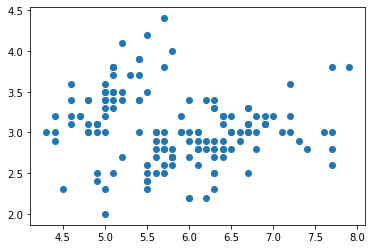

iteration 200 GB = 0.4167148369905737
best clusters so far =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 1 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 0 0 0 0 2 2 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 1 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


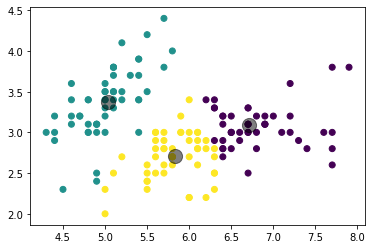

iteration 400 GB = 0.4163808512310048
best clusters so far =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 1 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 0 0 0 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 1 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


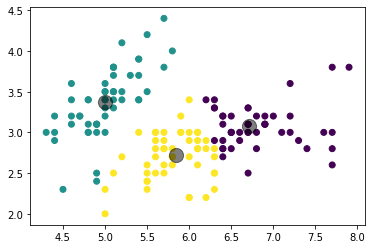

iteration 600 GB = 0.41638010744203097
best clusters so far =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 1 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 0 0 0 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 1 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


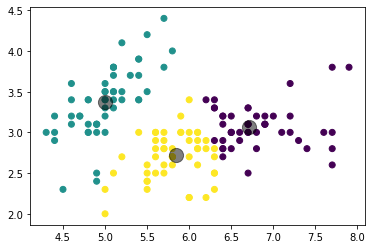

iteration 800 GB = 0.4163799225838402
best clusters so far =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 1 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 0 0 0 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 1 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


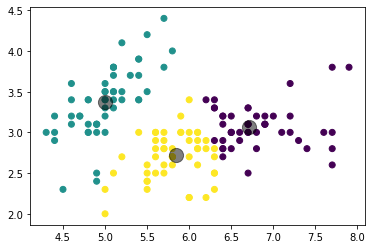

Finished!
Actual classes =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [55]:
import pandas as pd
import numpy as np
#from pso_clustering import PSOClusteringSwarm

plot = True
data_points = pd.read_csv('iris.txt', sep=',', header=None)
clusters = data_points[4].values
data_points = data_points.drop([4], axis=1)
# if you want to plot you can only show 2 points! so will use 2 points of data
if plot:
    data_points = data_points[[0, 1]]
# convert to numpy 2d array
data_points = data_points.values
pso = PSOClusteringSwarm(n_clusters=3, n_particles=10, data=data_points, hybrid=True)
pso.start(iteration=1000, plot=plot)

# For showing the actual clusters
mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
clusters = np.array([mapping[x] for x in clusters])
print('Actual classes = ', clusters)

In [59]:
clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [60]:
from sklearn import metrics
print(metrics.adjusted_rand_score(clusters, clusters1))

0.580368446890422
